In [79]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve, auc)

# XGBoost (handle import gracefully in case it's not available)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("XGBoost is available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available, will skip XGBoost models")

# SHAP for interpretability (handle import gracefully)
try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP is available")
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available, will skip SHAP analysis")

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")


XGBoost not available, will skip XGBoost models
SHAP not available, will skip SHAP analysis
All libraries imported successfully!


In [80]:
def load_data(file_path):
    """
    Load diabetes dataset from specified path
    
    Args:
        file_path (str): Path to the CSV file
    
    Returns:
        pd.DataFrame: Loaded dataset
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully!")
        print(f"Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load the dataset
DATA_PATH = 'diabetes.csv'
df = load_data(DATA_PATH)

if df is not None:
    print("\nFirst 5 rows:")
    print(df.head())



Dataset loaded successfully!
Shape: (768, 9)

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


EXPLORATORY DATA ANALYSIS

Dataset Shape: (768, 9)
Features: 8
Samples: 768

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Missing Values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin

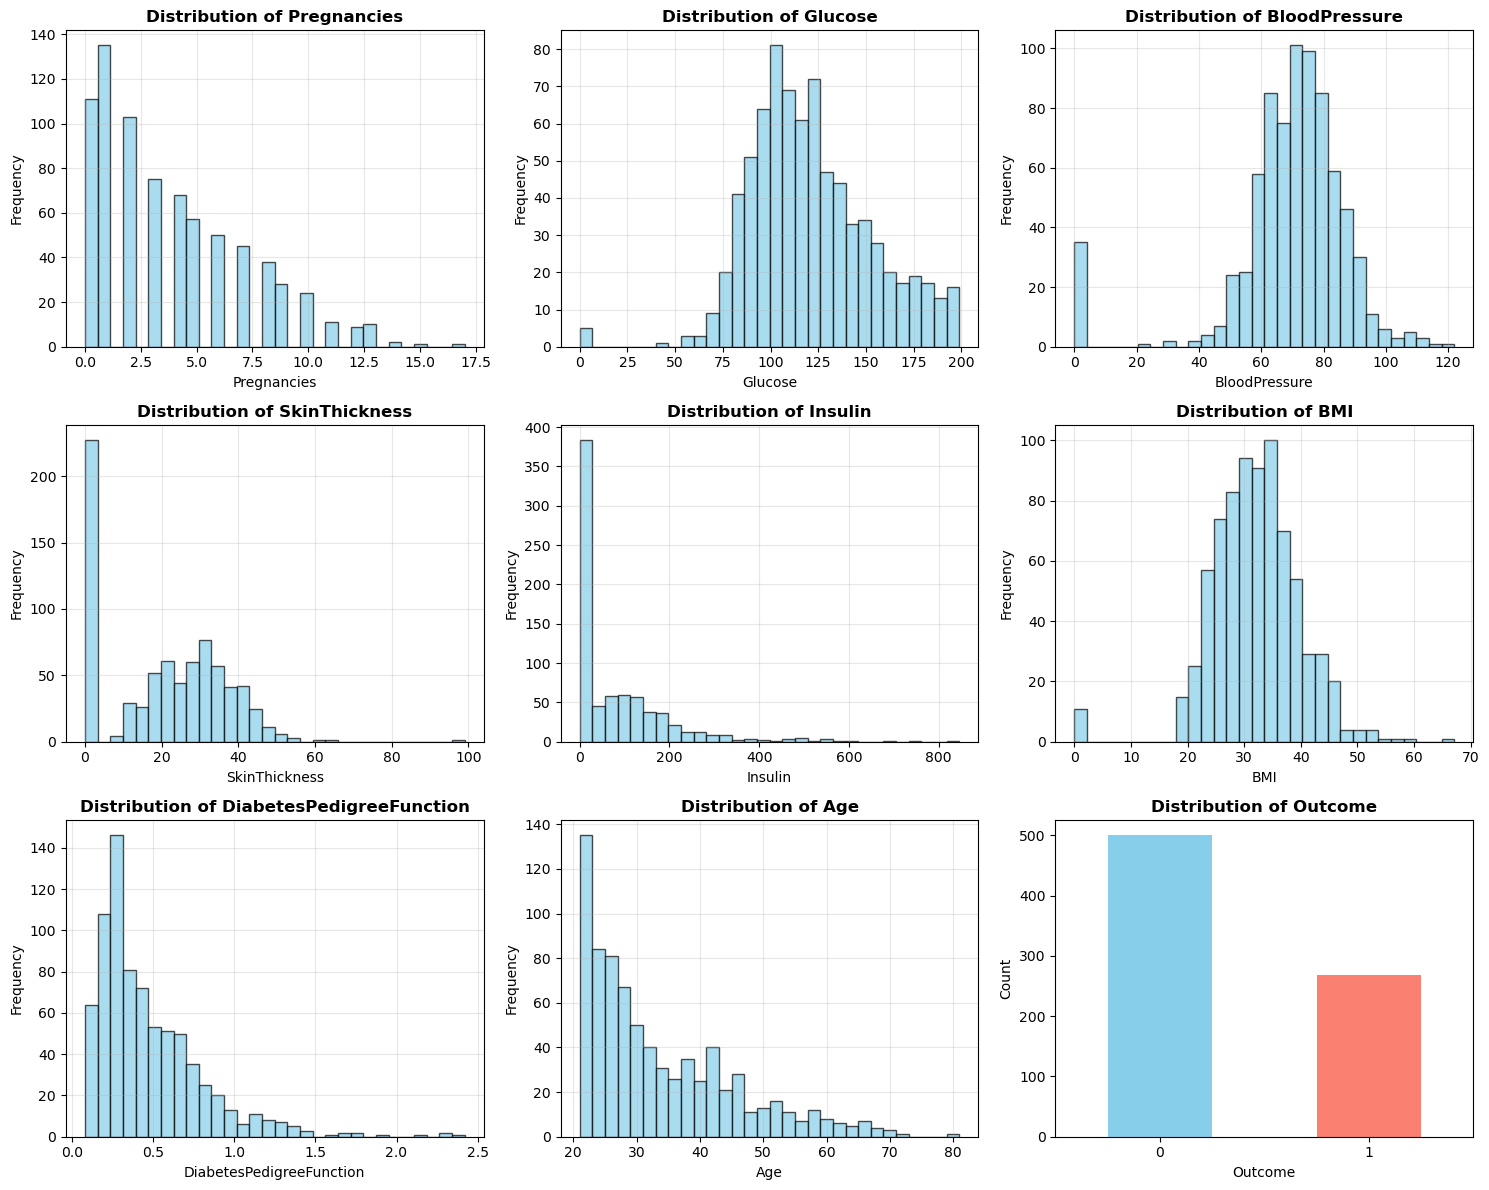

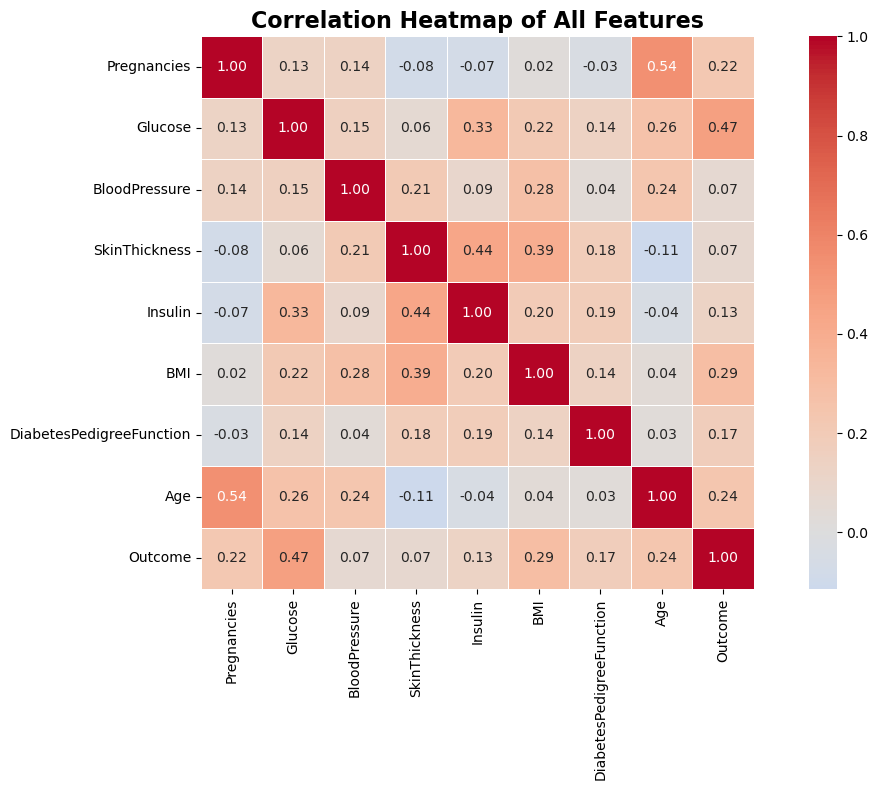


Correlation with Outcome (strongest first):
Glucose: 0.467
BMI: 0.293
Age: 0.238
Pregnancies: 0.222
DiabetesPedigreeFunction: 0.174
Insulin: 0.131
SkinThickness: 0.075
BloodPressure: 0.065


In [81]:
def perform_eda(df):
    """
    Perform comprehensive exploratory data analysis
    
    Args:
        df (pd.DataFrame): Input dataframe
    """
    print("="*60)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*60)
    
    # Basic information
    print(f"\nDataset Shape: {df.shape}")
    print(f"Features: {df.shape[1] - 1}")
    print(f"Samples: {df.shape[0]}")
    
    print("\nDataset Info:")
    print(df.info())
    
    print("\nMissing Values:")
    missing_vals = df.isnull().sum()
    print(missing_vals)
    
    if missing_vals.sum() == 0:
        print("No missing values found!")
    
    print("\nDescriptive Statistics:")
    print(df.describe())
    
    # Check for zero values in medical features (which shouldn't be zero)
    medical_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    print("\nZero values in medical features (likely missing data):")
    for feature in medical_features:
        if feature in df.columns:
            zero_count = (df[feature] == 0).sum()
            print(f"{feature}: {zero_count} ({zero_count/len(df)*100:.2f}%)")
    
    print("\nTarget Distribution:")
    target_counts = df['Outcome'].value_counts()
    print(target_counts)
    print(f"Class balance: {target_counts[0]} non-diabetic, {target_counts[1]} diabetic")
    print(f"Diabetes rate: {target_counts[1]/len(df)*100:.2f}%")

def plot_distributions(df):
    """
    Plot distributions of all features and target variable
    
    Args:
        df (pd.DataFrame): Input dataframe
    """
    # Set up the subplot grid
    n_cols = 3
    n_rows = (len(df.columns) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for i, column in enumerate(df.columns):
        ax = axes[i]
        
        if column == 'Outcome':
            # Bar plot for target variable
            df[column].value_counts().plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])
            ax.set_title(f'Distribution of {column}', fontweight='bold')
            ax.set_xlabel(column)
            ax.set_ylabel('Count')
            ax.tick_params(axis='x', rotation=0)
        else:
            # Histogram for continuous variables
            ax.hist(df[column], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            ax.set_title(f'Distribution of {column}', fontweight='bold')
            ax.set_xlabel(column)
            ax.set_ylabel('Frequency')
            ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df):
    """
    Plot correlation heatmap of all features
    
    Args:
        df (pd.DataFrame): Input dataframe
    """
    plt.figure(figsize=(12, 8))
    
    # Calculate correlation matrix
    corr_matrix = df.corr()
    
    # Create heatmap
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5,
                fmt='.2f')
    
    plt.title('Correlation Heatmap of All Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print strong correlations with target
    target_corr = corr_matrix['Outcome'].abs().sort_values(ascending=False)
    print("\nCorrelation with Outcome (strongest first):")
    for feature, corr in target_corr.items():
        if feature != 'Outcome':
            print(f"{feature}: {corr:.3f}")

# Perform EDA
if df is not None:
    perform_eda(df)
    plot_distributions(df)
    plot_correlation_heatmap(df)


In [82]:
def handle_zero_values(df):
    """
    Handle zero values in medical features by replacing with median
    
    Args:
        df (pd.DataFrame): Input dataframe
    
    Returns:
        pd.DataFrame: Processed dataframe
    """
    df_processed = df.copy()
    
    # Features that shouldn't have zero values
    zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    
    print("Handling zero values in medical features...")
    
    for feature in zero_features:
        if feature in df_processed.columns:
            # Replace 0 with NaN, then fill with median
            zero_mask = df_processed[feature] == 0
            if zero_mask.sum() > 0:
                print(f"Replacing {zero_mask.sum()} zero values in {feature}")
                df_processed.loc[zero_mask, feature] = np.nan
                median_val = df_processed[feature].median()
                df_processed[feature].fillna(median_val, inplace=True)
    
    return df_processed

def preprocess_data(df):
    """
    Complete preprocessing pipeline
    
    Args:
        df (pd.DataFrame): Input dataframe
    
    Returns:
        tuple: X_train, X_test, y_train, y_test, scaler
    """
    print("="*60)
    print("DATA PREPROCESSING")
    print("="*60)
    
    # Handle zero values
    df_processed = handle_zero_values(df)
    
    # Separate features and target
    X = df_processed.drop('Outcome', axis=1)
    y = df_processed['Outcome']
    
    print(f"\nFeatures shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTrain set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Train diabetes rate: {y_train.mean():.3f}")
    print(f"Test diabetes rate: {y_test.mean():.3f}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("\nFeatures scaled using StandardScaler")
    
    # Convert back to DataFrame for easier handling
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Preprocess the data
if df is not None:
    X_train, X_test, y_train, y_test, scaler = preprocess_data(df)


DATA PREPROCESSING
Handling zero values in medical features...
Replacing 5 zero values in Glucose
Replacing 35 zero values in BloodPressure
Replacing 227 zero values in SkinThickness
Replacing 374 zero values in Insulin
Replacing 11 zero values in BMI

Features shape: (768, 8)
Target shape: (768,)

Train set: 614 samples
Test set: 154 samples
Train diabetes rate: 0.349
Test diabetes rate: 0.351

Features scaled using StandardScaler


BASELINE MODEL TRAINING
Training Logistic Regression...

Logistic Regression Performance:
----------------------------------------
Test Accuracy:  0.7078
Test Precision: 0.6000
Test Recall:    0.5000
Test F1-Score:  0.5455
Test AUC-ROC:   0.8130
CV AUC: 0.8432 ± 0.0293
Training Random Forest...

Random Forest Performance:
----------------------------------------
Test Accuracy:  0.7792
Test Precision: 0.7174
Test Recall:    0.6111
Test F1-Score:  0.6600
Test AUC-ROC:   0.8179
CV AUC: 0.8248 ± 0.0226


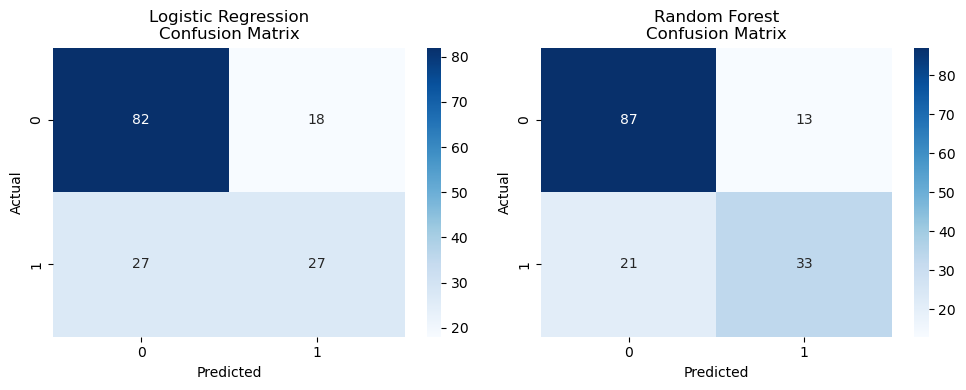

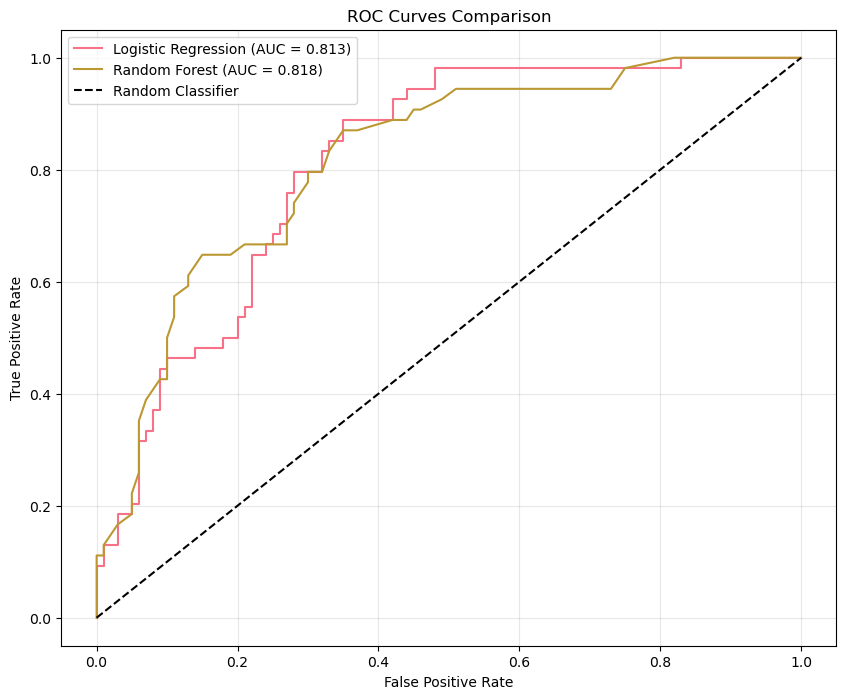

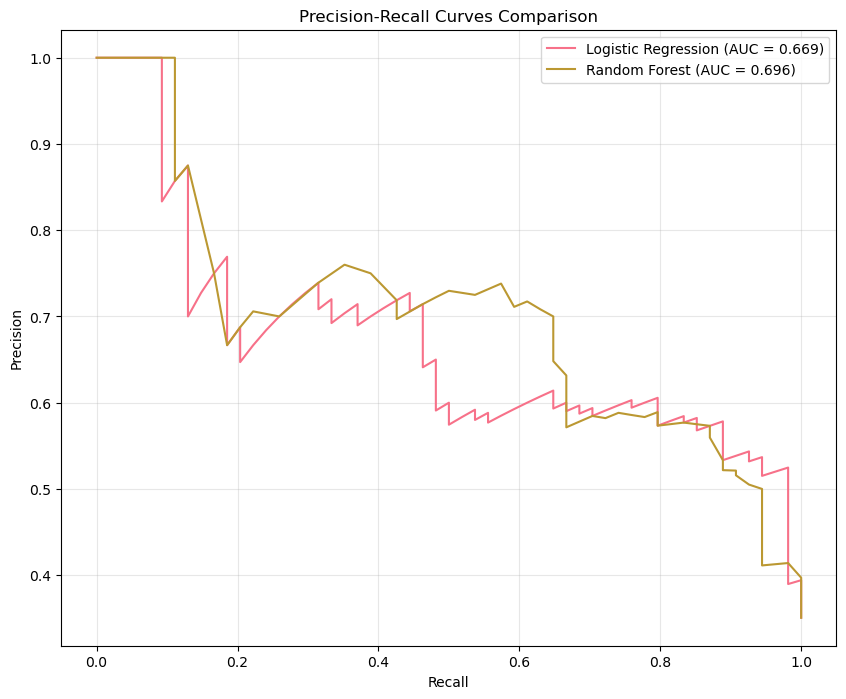

In [83]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Comprehensive model evaluation
    
    Args:
        model: Trained model
        X_train, X_test: Feature sets
        y_train, y_test: Target sets
        model_name (str): Name of the model
    
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilities for AUC calculation
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'model_name': model_name,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'train_auc': roc_auc_score(y_train, y_train_prob),
        'test_auc': roc_auc_score(y_test, y_test_prob)
    }
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    metrics['cv_auc_mean'] = cv_scores.mean()
    metrics['cv_auc_std'] = cv_scores.std()
    
    print(f"\n{model_name} Performance:")
    print("-" * 40)
    print(f"Test Accuracy:  {metrics['test_accuracy']:.4f}")
    print(f"Test Precision: {metrics['test_precision']:.4f}")
    print(f"Test Recall:    {metrics['test_recall']:.4f}")
    print(f"Test F1-Score:  {metrics['test_f1']:.4f}")
    print(f"Test AUC-ROC:   {metrics['test_auc']:.4f}")
    print(f"CV AUC: {metrics['cv_auc_mean']:.4f} ± {metrics['cv_auc_std']:.4f}")
    
    return metrics

def train_baseline_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate baseline models
    
    Returns:
        dict: Dictionary containing trained models and their metrics
    """
    print("="*60)
    print("BASELINE MODEL TRAINING")
    print("="*60)
    
    models = {}
    results = []
    
    # Logistic Regression
    print("Training Logistic Regression...")
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train, y_train)
    models['logistic_regression'] = lr
    lr_metrics = evaluate_model(lr, X_train, X_test, y_train, y_test, "Logistic Regression")
    results.append(lr_metrics)
    
    # Random Forest
    print("Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    models['random_forest'] = rf
    rf_metrics = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")
    results.append(rf_metrics)
    
    # XGBoost (if available)
    if XGBOOST_AVAILABLE:
        print("Training XGBoost...")
        xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
        xgb_model.fit(X_train, y_train)
        models['xgboost'] = xgb_model
        xgb_metrics = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")
        results.append(xgb_metrics)
    
    return models, results

def plot_confusion_matrices(models, X_test, y_test):
    """
    Plot confusion matrices for all models
    """
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    
    if n_models == 1:
        axes = [axes]
    
    for i, (model_name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{model_name.replace("_", " ").title()}\nConfusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(models, X_test, y_test):
    """
    Plot ROC curves for all models
    """
    plt.figure(figsize=(10, 8))
    
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{model_name.replace("_", " ").title()} (AUC = {auc_score:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_precision_recall_curves(models, X_test, y_test):
    """
    Plot Precision-Recall curves for all models
    """
    plt.figure(figsize=(10, 8))
    
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        auc_score = auc(recall, precision)
        
        plt.plot(recall, precision, label=f'{model_name.replace("_", " ").title()} (AUC = {auc_score:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Train baseline models
if df is not None:
    models, results = train_baseline_models(X_train, X_test, y_train, y_test)
    
    # Plot evaluations
    plot_confusion_matrices(models, X_test, y_test)
    plot_roc_curves(models, X_test, y_test)
    plot_precision_recall_curves(models, X_test, y_test)


In [84]:
def tune_random_forest(X_train, y_train):
    """
    Tune Random Forest hyperparameters using RandomizedSearchCV
    """
    print("="*60)
    print("HYPERPARAMETER TUNING - RANDOM FOREST")
    print("="*60)
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    rf = RandomForestClassifier(random_state=42)
    
    # RandomizedSearchCV for efficiency
    rf_random = RandomizedSearchCV(
        rf, param_grid, n_iter=50, cv=5, 
        scoring='roc_auc', n_jobs=-1, random_state=42
    )
    
    print("Tuning Random Forest... This may take a few minutes.")
    rf_random.fit(X_train, y_train)
    
    print(f"Best parameters: {rf_random.best_params_}")
    print(f"Best CV AUC: {rf_random.best_score_:.4f}")
    
    return rf_random.best_estimator_

def tune_logistic_regression(X_train, y_train):
    """
    Tune Logistic Regression hyperparameters using GridSearchCV
    """
    print("="*60)
    print("HYPERPARAMETER TUNING - LOGISTIC REGRESSION")
    print("="*60)
    
    # Define parameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    
    lr = LogisticRegression(random_state=42, max_iter=1000)
    
    lr_grid = GridSearchCV(
        lr, param_grid, cv=5, scoring='roc_auc', n_jobs=-1
    )
    
    print("Tuning Logistic Regression...")
    lr_grid.fit(X_train, y_train)
    
    print(f"Best parameters: {lr_grid.best_params_}")
    print(f"Best CV AUC: {lr_grid.best_score_:.4f}")
    
    return lr_grid.best_estimator_

# Hyperparameter tuning
if df is not None:
    best_rf = tune_random_forest(X_train, y_train)
    best_lr = tune_logistic_regression(X_train, y_train)
    
    # Evaluate tuned models
    print("\n" + "="*60)
    print("TUNED MODELS EVALUATION")
    print("="*60)
    
    tuned_models = {
        'tuned_random_forest': best_rf,
        'tuned_logistic_regression': best_lr
    }
    
    tuned_results = []
    for name, model in tuned_models.items():
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test, 
                                name.replace('_', ' ').title())
        tuned_results.append(metrics)


HYPERPARAMETER TUNING - RANDOM FOREST
Tuning Random Forest... This may take a few minutes.
Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': True}
Best CV AUC: 0.8371
HYPERPARAMETER TUNING - LOGISTIC REGRESSION
Tuning Logistic Regression...
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV AUC: 0.8433

TUNED MODELS EVALUATION

Tuned Random Forest Performance:
----------------------------------------
Test Accuracy:  0.7532
Test Precision: 0.6818
Test Recall:    0.5556
Test F1-Score:  0.6122
Test AUC-ROC:   0.8128
CV AUC: 0.8371 ± 0.0200

Tuned Logistic Regression Performance:
----------------------------------------
Test Accuracy:  0.6948
Test Precision: 0.5745
Test Recall:    0.5000
Test F1-Score:  0.5347
Test AUC-ROC:   0.8128
CV AUC: 0.8433 ± 0.0291


FEATURE IMPORTANCE ANALYSIS


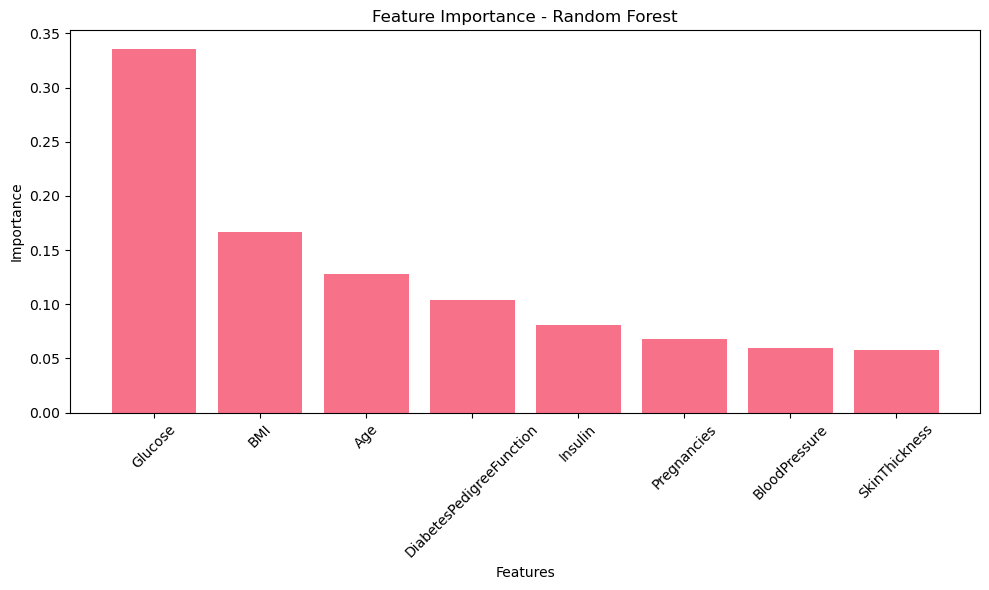


Top 5 Important Features (Random Forest):
1. Glucose: 0.3361
2. BMI: 0.1664
3. Age: 0.1276
4. DiabetesPedigreeFunction: 0.1035
5. Insulin: 0.0810


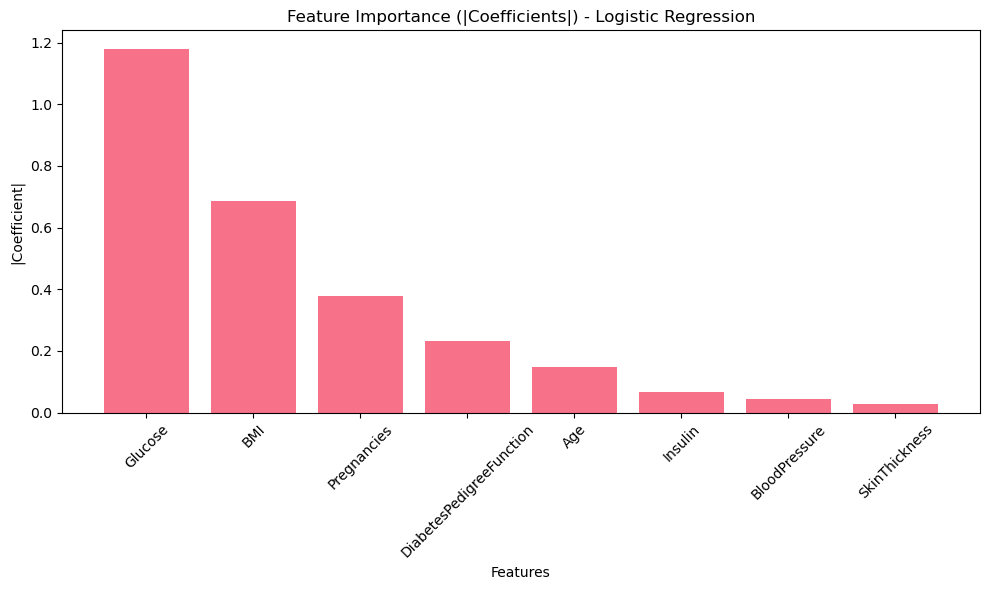


Top 5 Important Features (Logistic Regression):
1. Glucose: 1.1806
2. BMI: 0.6872
3. Pregnancies: 0.3765
4. DiabetesPedigreeFunction: 0.2332
5. Age: 0.1473


In [85]:
def plot_feature_importance(model, feature_names, model_name):
    """
    Plot feature importance for tree-based models
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop 5 Important Features ({model_name}):")
        for i in range(min(5, len(importances))):
            idx = indices[i]
            print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")
    
    elif hasattr(model, 'coef_'):
        # For linear models, show coefficient magnitudes
        coef = np.abs(model.coef_[0])
        indices = np.argsort(coef)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(coef)), coef[indices])
        plt.xticks(range(len(coef)), [feature_names[i] for i in indices], rotation=45)
        plt.title(f'Feature Importance (|Coefficients|) - {model_name}')
        plt.xlabel('Features')
        plt.ylabel('|Coefficient|')
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop 5 Important Features ({model_name}):")
        for i in range(min(5, len(coef))):
            idx = indices[i]
            print(f"{i+1}. {feature_names[idx]}: {coef[idx]:.4f}")

def shap_analysis(model, X_train, X_test, model_name):
    """
    SHAP analysis for model interpretability
    """
    if not SHAP_AVAILABLE:
        print("SHAP not available for interpretability analysis")
        return
    
    print(f"\nSHAP Analysis for {model_name}")
    print("-" * 40)
    
    # Create explainer based on model type
    if hasattr(model, 'predict_proba'):
        if 'forest' in model_name.lower() or 'xgb' in model_name.lower():
            explainer = shap.TreeExplainer(model)
        else:
            explainer = shap.Explainer(model, X_train[:100])  # Sample for efficiency
    else:
        explainer = shap.LinearExplainer(model, X_train)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test[:100])  # Sample for efficiency
    
    # Handle different SHAP value formats
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # For binary classification, use positive class
    
    # Summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test[:100], show=False)
    plt.title(f'SHAP Summary Plot - {model_name}')
    plt.tight_layout()
    plt.show()

# Feature importance analysis
if df is not None:
    feature_names = X_train.columns.tolist()
    
    print("="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Plot feature importance for the best models
    plot_feature_importance(best_rf, feature_names, "Random Forest")
    plot_feature_importance(best_lr, feature_names, "Logistic Regression")
    
    # SHAP analysis
    if SHAP_AVAILABLE:
        shap_analysis(best_rf, X_train, X_test, "Random Forest")


FINAL RESULTS SUMMARY

Model Performance Comparison:
                    Model  Accuracy  Precision  Recall     F1  Test AUC  CV AUC
      Logistic Regression    0.7078     0.6000  0.5000 0.5455    0.8130  0.8432
            Random Forest    0.7792     0.7174  0.6111 0.6600    0.8179  0.8248
      Tuned Random Forest    0.7532     0.6818  0.5556 0.6122    0.8128  0.8371
Tuned Logistic Regression    0.6948     0.5745  0.5000 0.5347    0.8128  0.8433

Best Model: Random Forest
Best Test AUC: 0.8179
FINAL MODEL EVALUATION: Random Forest

Final Test Set Performance:
Accuracy:  0.6948
Precision: 0.5745
Recall:    0.5000
F1-Score:  0.5347
AUC-ROC:   0.8128

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       100
           1       0.57      0.50      0.53        54

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69  

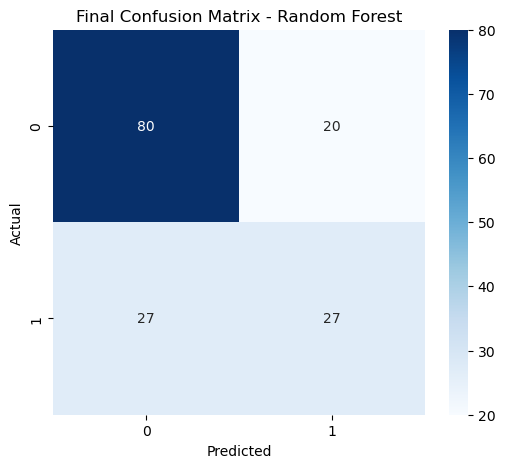


PIPELINE COMPLETED SUCCESSFULLY!
Best Model: Random Forest
Final AUC: 0.8128

Model is ready for deployment!


In [86]:
def select_best_model(results):
    """
    Select the best model based on test AUC
    """
    best_result = max(results, key=lambda x: x['test_auc'])
    return best_result

def create_results_summary(results):
    """
    Create a comprehensive results summary
    """
    print("="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    
    # Convert results to DataFrame for better display
    results_df = pd.DataFrame(results)
    
    # Select relevant columns
    display_cols = ['model_name', 'test_accuracy', 'test_precision', 'test_recall', 
                   'test_f1', 'test_auc', 'cv_auc_mean']
    
    summary_df = results_df[display_cols].round(4)
    summary_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'Test AUC', 'CV AUC']
    
    print("\nModel Performance Comparison:")
    print(summary_df.to_string(index=False))
    
    # Find best model
    best_idx = results_df['test_auc'].idxmax()
    best_model_name = results_df.loc[best_idx, 'model_name']
    best_auc = results_df.loc[best_idx, 'test_auc']
    
    print(f"\nBest Model: {best_model_name}")
    print(f"Best Test AUC: {best_auc:.4f}")
    
    return best_model_name, summary_df

def final_model_evaluation(best_model, X_train, X_test, y_train, y_test, model_name):
    """
    Final comprehensive evaluation of the best model
    """
    print("="*60)
    print(f"FINAL MODEL EVALUATION: {model_name}")
    print("="*60)
    
    # Retrain on full training set
    best_model.fit(X_train, y_train)
    
    # Final predictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Comprehensive metrics
    print(f"\nFinal Test Set Performance:")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_test, y_prob):.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Final confusion matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Final Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return best_model

# Final evaluation
if df is not None:
    # Combine all results
    all_results = results + tuned_results
    
    # Create summary
    best_model_name, summary_df = create_results_summary(all_results)
    
    # Select the best model
    if 'random_forest' in best_model_name.lower():
        final_model = best_rf
    else:
        final_model = best_lr
    
    # Final evaluation
    final_trained_model = final_model_evaluation(final_model, X_train, X_test, 
                                               y_train, y_test, best_model_name)
    
    print("\n" + "="*60)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*60)
    print(f"Best Model: {best_model_name}")
    print(f"Final AUC: {roc_auc_score(y_test, final_trained_model.predict_proba(X_test)[:, 1]):.4f}")
    print("\nModel is ready for deployment!")


In [87]:
import joblib

if 'final_trained_model' in locals():
	joblib.dump(final_trained_model, "diabetes_model.pkl")
	print("Model saved as diabetes_model.pkl")
else:
	print("final_trained_model is not defined. Please ensure the model is trained before saving.")



Model saved as diabetes_model.pkl
